# Niche detection using scimap's `spatial_count` and `spatial_cluster`

In [195]:
## Imports
import scimap as sm
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import glob
import time

In [196]:
## Load data

cluster_labels = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/model201710_cluster_labels_phenograph_recoded.csv')
fn_2D = "../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_2D/measured_mask_centroids_2D_*.csv"
files_2D = np.array(glob.glob(fn_2D)) ## unsorted list of files (full path)
centroids_2D = pd.concat([pd.read_csv(file) for file in files_2D])
centroids_3D = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_3D.csv')

centroids_2D.sort_values(by='z', inplace=True)
## Recode cluster labels to avoid conversion to int in sm function (issue opened)
cluster_labels.loc[ cluster_labels['ct_broad'].isna(), 'ct_broad' ] = 'label_' + cluster_labels.loc[ cluster_labels['ct_broad'].isna(), 'phenograph' ].astype(str)
## Group T cell subtypes together (T, T_CD8a-)
cluster_labels.loc[ cluster_labels['ct_broad']=='T_CD8a-', 'ct_broad' ] = 'T'

## Merge cluster labels with centroids
data2D = pd.merge(centroids_2D, cluster_labels, on='id') ## id = cell id, z = imageid
data3D = pd.merge(centroids_3D, cluster_labels, on='id') ## id = cell id
data3D['imageid'] = np.repeat('imageid', data3D.shape[0]) ## placeholder

## To AnnData object
adata2 = ad.AnnData(obs=data2D)
adata3 = ad.AnnData(obs=data3D)

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/home/gesa/.py_venv/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



In [197]:
## Get NBH size equivalent
knn_2D = 10
knn2to3 = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/knn_2D_to_3D.csv')
knn_3D = knn2to3.loc[ knn2to3['knn_2D'] == knn_2D, 'knn_3D'].values[0]
knn_3D

39

In [198]:
## spatial_count
t0 = time.process_time()
sm.tl.spatial_count(adata3, phenotype='ct_broad', x_coordinate='x', y_coordinate='y', z_coordinate='z',
                    method='knn', knn=knn_3D, verbose=False)
t1 = time.process_time()
sm.tl.spatial_count(adata2, phenotype='ct_broad', x_coordinate='x', y_coordinate='y', z_coordinate=None, imageid='z',
                    method='knn', knn=knn_2D, verbose=False)
print("Time elapsed for 3D data: ", time.strftime('%H:%M:%S', time.gmtime(int(t1-t0))) )
print("Time elapsed for 2D data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t1))) )

Time elapsed for 3D data:  00:00:20
Time elapsed for 2D data:  00:00:17


In [18]:
adata3.uns['spatial_count']

neighbour_phenotype,B,CD86+,T,endothelial,epithelial,label_-1,label_14,label_15,label_16,label_19,...,label_32,label_33,label_34,label_35,label_36,label_37,label_8,label_9,macrophage,stromal
0,0.000000,0.052632,0.000000,0.000000,0.631579,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.157895,0.0,0.0,0.105263,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.736842,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.157895,0.0,0.0,0.052632,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.868421,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.078947,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.894737,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.052632,0.0,0.0,0.052632,0.000000,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.921053,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.078947,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108482,0.052632,0.000000,0.052632,0.052632,0.500000,0.026316,0.078947,0.105263,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.052632,0.0,0.000000
108483,0.000000,0.026316,0.000000,0.000000,0.394737,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.526316,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
108484,0.000000,0.000000,0.342105,0.000000,0.026316,0.078947,0.210526,0.026316,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.052632,0.078947,0.0,0.026316
108485,0.052632,0.000000,0.052632,0.078947,0.368421,0.078947,0.105263,0.131579,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.078947,0.0,0.000000


In [21]:
adata2.uns['spatial_count']

neighbour_phenotype,B,CD86+,T,endothelial,epithelial,label_-1,label_14,label_15,label_16,label_19,...,label_32,label_33,label_34,label_35,label_36,label_8,label_9,macrophage,stromal,label_37
0,0.000000,0.0,0.000000,0.0,0.555556,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.111111,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.333333,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.111111,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.666667,0.000000,0.111111,0.111111,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.333333,0.000000,0.444444,0.111111,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.555556,0.000000,0.222222,0.222222,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380964,0.000000,0.0,0.777778,0.0,0.000000,0.000000,0.111111,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0
380965,0.000000,0.0,0.444444,0.0,0.000000,0.111111,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.222222,0.000000,0.0,0.0,0.0
380966,0.111111,0.0,0.666667,0.0,0.000000,0.111111,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.111111,0.0,0.0,0.0
380967,0.222222,0.0,0.444444,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.222222,0.000000,0.0,0.0,0.0


In [199]:
## spatial_cluster
k_clusters = 5

t0 = time.process_time()
sm.tl.spatial_cluster(adata3,
                      method='kmeans', k=k_clusters, random_state=42, verbose=False)
t1 = time.process_time()
sm.tl.spatial_cluster(adata2,
                      method='kmeans', k=k_clusters, random_state=42, verbose=False)
print("Time elapsed for 3D data: ", time.strftime('%H:%M:%S', time.gmtime(int(t1-t0))) )
print("Time elapsed for 2D data: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t1))) )

Kmeans clustering
Kmeans clustering
Time elapsed for 3D data:  00:00:33
Time elapsed for 2D data:  00:01:04


In [26]:
adata3.obs

,z,y,x,id,phenograph,ct_broad,imageid,spatial_kmeans
0,283.49,283.11,338.93,20200,5,epithelial,imageid,3
1,282.65,283.79,322.07,20201,12,epithelial,imageid,3
2,283.38,281.36,235.34,20203,11,epithelial,imageid,0
3,282.55,281.82,283.25,20204,12,epithelial,imageid,0
4,282.78,281.50,250.13,20205,11,epithelial,imageid,0
...,...,...,...,...,...,...,...,...
108482,0.50,1.58,595.50,251817,14,label_14,imageid,3
108483,0.98,4.17,402.68,251819,3,epithelial,imageid,4
108484,1.36,1.57,187.49,251820,14,label_14,imageid,2
108485,1.38,1.44,601.32,251822,14,label_14,imageid,1


In [28]:
adata2.obs

,z,y,x,id,phenograph,ct_broad,spatial_kmeans
0,0,191.59,192.34,246939,1,epithelial,0
1,0,186.64,128.28,246941,12,epithelial,0
2,0,180.38,298.04,246946,2,epithelial,0
3,0,175.31,412.30,246947,3,epithelial,0
4,0,176.58,328.54,246950,13,T,0
...,...,...,...,...,...,...,...
380964,151,466.83,369.62,674,29,label_29,3
380965,151,465.29,356.15,675,13,T,3
380966,151,472.64,264.18,654,25,B,3
380967,151,484.96,333.47,599,-1,label_-1,3


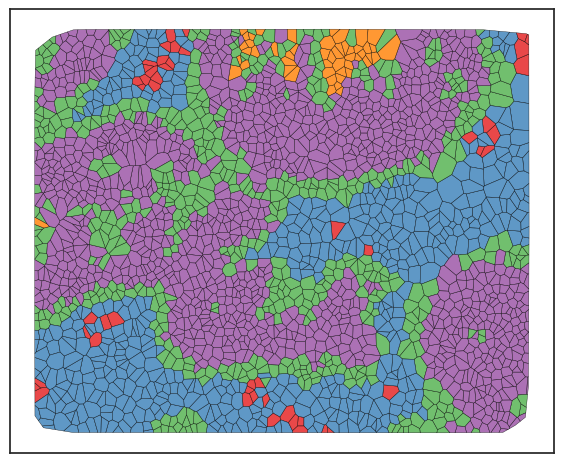

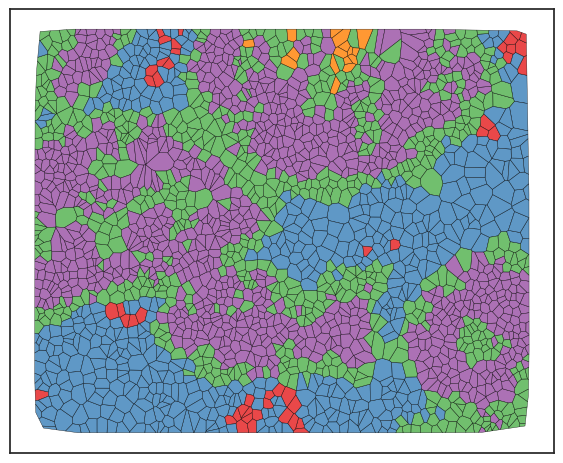

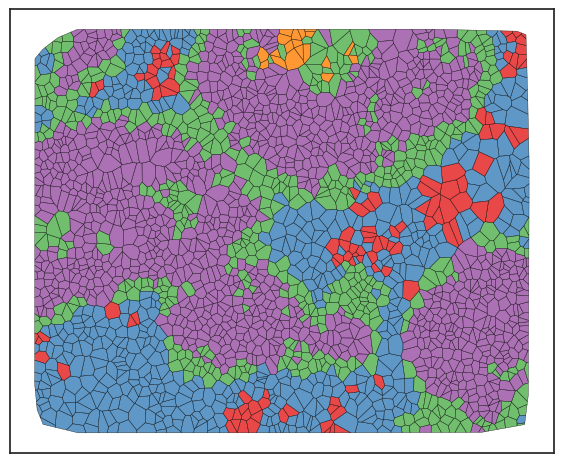

In [152]:
## Plot results on exemplary 2D images
rng = np.random.default_rng(42)
subset = rng.choice(adata2.obs['z'].unique(), 1)

for i in range(3):
    sm.pl.voronoi(adata2, subset=subset[0]+i, imageid='z',
                x_coordinate='x', y_coordinate='y',
                color_by='spatial_kmeans', 
                voronoi_edge_color = 'black',
                voronoi_line_width = 0.3, 
                voronoi_alpha = 0.8, 
                size_max=3000,
                overlay_points=None, 
                plot_legend=True, # FIXME: legend not showing
                legend_size=6)

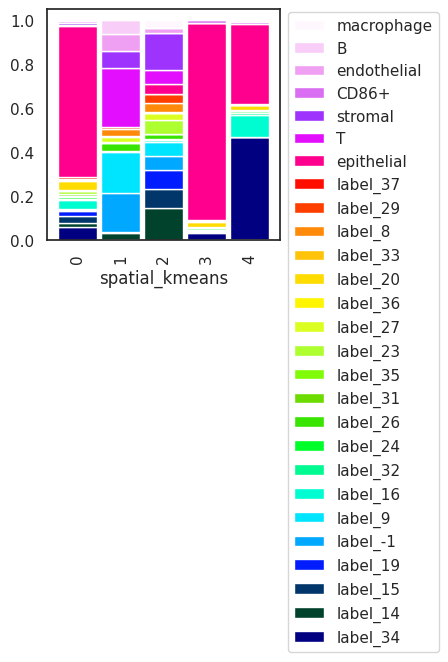

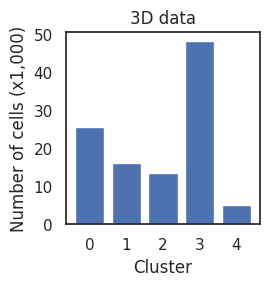

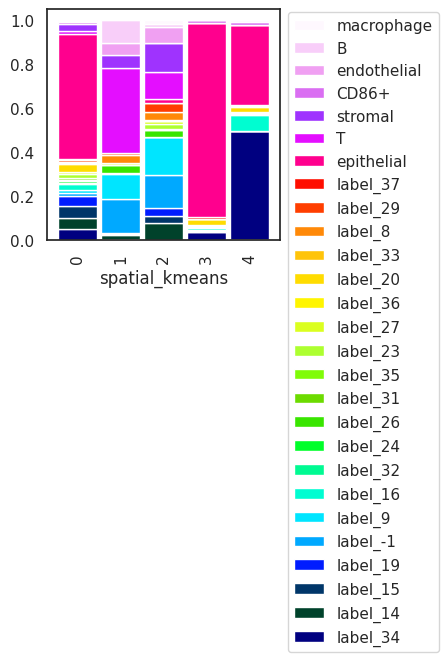

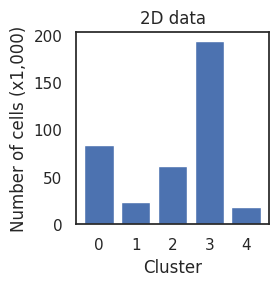

In [201]:
## Plot cluster compositions

## Recode equivalent cluster labels in 2D
## The manual assignment needs to be re-done for every clustering run, since names change
cluster_labels_recode = {0:3, 1:2, 2:1, 3:0, 4:4}
adata2.obs['spatial_kmeans_orig'] = adata2.obs['spatial_kmeans']
adata2.obs['spatial_kmeans'] = adata2.obs['spatial_kmeans_orig'].astype(int).map(cluster_labels_recode)

## Sort cell types
ctypes = adata2.obs['ct_broad'].unique().astype(str)
is_label = np.array([ str(s).startswith('label_') for s in ctypes ])
order = np.concatenate([ctypes[is_label], ctypes[~is_label]])
#adata2.obs = adata2.obs.set_index('ct_broad').loc[ order, : ].reset_index(drop=False)
#adata3.obs = adata3.obs.set_index('ct_broad').loc[ order, : ].reset_index(drop=False)

for i, adata in enumerate([adata3, adata2]):
    ## default cluster composition plot
    df = sm.pl.stacked_barplot(adata, x_axis='spatial_kmeans', y_axis='ct_broad', return_data=True,
                               method='percent', order_yaxis=order, figsize=(3,3))
    ## cluster abundance plot
    ccounts = adata.obs['spatial_kmeans'].value_counts().sort_index() / 1000
    plt.subplots(figsize=(2.5,2.5))
    plt.bar(ccounts.index, ccounts.values)
    plt.xticks(ccounts.index)
    plt.xlabel('Cluster')
    plt.ylabel('Number of cells (x1,000)')
    plt.title(f'{["3D", "2D"][i]} data')
    plt.show()

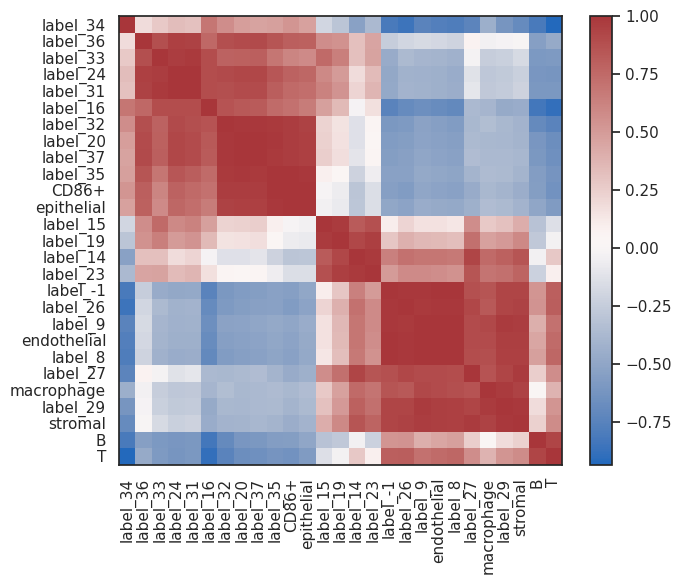

In [150]:
sm.pl.groupCorrelation(adata2, groupBy='ct_broad', condition='spatial_kmeans', figsize=(7,6))

## Comparing results between 3D and 2D

In [216]:
from sklearn.metrics import adjusted_rand_score

img_ids = adata2.obs['z'].unique()
ari = np.empty(img_ids.size)
for i, img_id in enumerate(img_ids):
    ## Match cells between 2D and 3D by id
    adata2_subset = adata2.obs.loc[ adata2.obs['z'] == img_id , : ]
    adata3_ids = adata3.obs.set_index('id').loc[ adata2_subset['id'].values, 'spatial_kmeans' ].astype(float).values
    adata2_ids = adata2_subset['spatial_kmeans'].astype(float).values
    ## Remove NaNs in either vector
    adata3_ids = adata3_ids[ ~np.isnan(adata3_ids) & ~np.isnan(adata2_ids) ].astype(int)
    adata2_ids = adata2_ids[ ~np.isnan(adata3_ids) & ~np.isnan(adata2_ids) ].astype(int)
    if not len(adata3_ids): ## No cells
        ari[i] = np.nan
    else: ## Calculate adjusted rand index
        ari[i] = adjusted_rand_score(adata3_ids, adata2_ids)

mean 0.54 +- 0.08 sdev
max. value at image 24 with ARI = 0.65
min. value at image 0 with ARI = 0.2


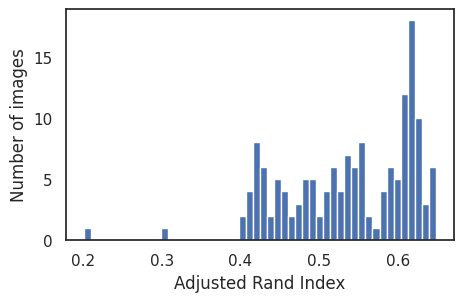

In [219]:
print(f'mean {ari.mean():.2} +- {ari.std():.2} sdev')
print(f'max. value at image {img_ids[ np.where(ari == ari.max())[0][0] ]} with ARI = {ari.max():.2}')
print(f'min. value at image {img_ids[ np.where(ari == ari.min())[0][0] ]} with ARI = {ari.min():.2}')

plt.figure(figsize=(5,3))
plt.hist(ari, bins=50)
plt.xlabel('Adjusted Rand Index')
plt.ylabel('Number of images')
plt.show()